In [5]:
import torch
import pandas as pd
import json
# from torch.utils.data import DataLoader, SequentialSampler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain
from tqdm.auto import tqdm
from pathlib import Path

from dataset import TwitterDataset
from autoencoders import load_encoder

dset = TwitterDataset(
    'timestamp',
    spam_idx_path="spam_idx.pkl",
    sentiment_path='sentiment/vader/',
    # whole_text_path = 'whole_text',
    # token_path = 'tokens/text',
    embedding_path = 'embeddings/all-MiniLM-L6-v2/',
)

loading from timestamp:   0%|          | 0/221 [00:00<?, ?it/s]

loading sentiment..:   0%|          | 0/221 [00:00<?, ?it/s]

loading embeddings..:   0%|          | 0/221 [00:00<?, ?it/s]

no spam here!
loaded dataset. took 377.1635274272412 ms. Got 20050096 items


In [6]:
model = load_encoder('models/LinearAutoEncoder.pkl','linear')
for p in model.parameters():
    p.requires_grad = False

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import time

size = 1000000
model = model.cuda()

#find elbow using inertia and distortion
#use minibatch for optimal k computation to speed up calculations
cluster_count = range(2, 20)
batched_elbows = [0]*len(cluster_count)
km_multiple = [MiniBatchKMeans(n_clusters=i, max_iter=100) for i in cluster_count]

In [9]:
it_count = 0
for i in range(len(dset.embedding)):
  it_count+=1
  start = time.perf_counter()
  
  inp = dset.embedding[i*size: (i+1)*size].cuda()
  out = model.encoder(inp).cpu().numpy()
  if len(out) == 0:
    break
  
  fits = [i.fit(out) for i in km_multiple]
  inertias = [i.inertia_ for i in fits]
  #s_start = time.perf_counter()
  #s_scores = [silhouette_score(out, i.labels_) for i in fits]
  #sillhouettes = [a+b for a,b in zip(s_scores, sillhouettes)]
  #s_time = time.perf_counter()-start
  #print(s_time)
  batched_elbows = [a+b for a, b in zip(inertias, batched_elbows)]
  del out

  print("Iteration", it_count, f"Time taken:  {time.perf_counter()-start} seconds")
  #break
  #jsquared errors for evaluating internal consistency in clusters

Iteration 1 Time taken:  53.089634001255035 seconds
Iteration 2 Time taken:  32.10535794496536 seconds
Iteration 3 Time taken:  42.585597675293684 seconds
Iteration 4 Time taken:  35.83697543106973 seconds
Iteration 5 Time taken:  46.34865444898605 seconds
Iteration 6 Time taken:  41.57170909270644 seconds
Iteration 7 Time taken:  42.128497552126646 seconds
Iteration 8 Time taken:  51.03863790072501 seconds
Iteration 9 Time taken:  41.28035007789731 seconds
Iteration 10 Time taken:  41.36220138147473 seconds
Iteration 11 Time taken:  42.85833535157144 seconds
Iteration 12 Time taken:  42.82435336522758 seconds
Iteration 13 Time taken:  35.58587187714875 seconds
Iteration 14 Time taken:  44.545505825430155 seconds
Iteration 15 Time taken:  50.78384674154222 seconds
Iteration 16 Time taken:  45.05524048767984 seconds
Iteration 17 Time taken:  45.217960711568594 seconds
Iteration 18 Time taken:  46.52617862075567 seconds
Iteration 19 Time taken:  52.85369892977178 seconds
Iteration 20 Tim

In [11]:
from kneed import KneeLocator
knee_loc = KneeLocator(range(2, 20), batched_elbows, curve="convex", direction="decreasing")
knee_loc.elbow

7

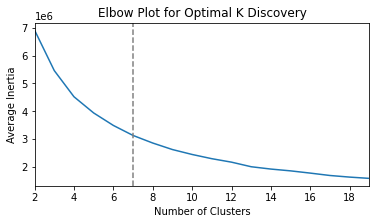

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

results = [x/it_count for x in batched_elbows]
plt.figure(figsize=(6, 3))
plt.plot(cluster_count, results)
plt.xlim(2, 19)
plt.title("Elbow Plot for Optimal K Discovery")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Inertia")
plt.axvline(x=knee_loc.elbow, color="grey", linestyle='--')
plt.show()

plt.savefig('kmeans_elbow.pdf')

In [ ]:
from sklearn.cluster import DBSCAN

batched_dbelbows = [0]*len(cluster_count)
db_multiple = [DBSCAN(n_clusters=i, max_iter=100) for i in cluster_count]